### MC FOM method with merged ports

In [1]:
# import stuff
import sys,os,os.path

sys.path.append("../../")   # cite IC from parent directory
sys.path.append("/home/e78368jw/Documents/NEXT_CODE/next_misc/")
#sys.path.append(os.path.expanduser('~/code/eol_hsrl_python'))
os.environ['ICTDIR']='/home/e78368jw/Documents/NEXT_CODE/IC'

from    IC.invisible_cities.core.core_functions   import shift_to_bin_centers

import core.functions as func
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd



import scipy.special as special
from scipy.stats import skewnorm
from scipy.optimize import curve_fit

from scipy.integrate import quad

In [20]:
# ugly functions
def histogram_fit(fnc, sig_data, binning, p0, fit_labels, bounds = []):
    '''
    fit a function from histogram data, return the fitting parameters
    '''


    # Use positron data to collect the C1 and C2 values from the signal fit
    s_cnts, s_edges, s_patches = func.plot_hist(sig_data, binning = binning, log = False, data = True)

    
    s_centres = shift_to_bin_centers(s_edges)

    # FIT
    if (bounds == []):
        return curve_fit(fnc, s_centres, s_cnts, p0, maxfev = 500000)
    else:
        return curve_fit(fnc, s_centres, s_cnts, p0, maxfev = 500000, bounds = bounds)

def fom_calc_MC(cut_data, positron_data, cut_list, binning = 80, verbose = False):
    '''
        calculate FOM via fitting using MC information for C1 and C2
        start the cut list at non-zero. eg cut_list = [0.1, 0.2, ...]
    '''
    # preset some parameters for sanity purposes
    emin = 1.5
    emax = 1.7


    # select only events in which events have positrons
    sig_data = cut_data[cut_data['event'].isin(positron_data['event_id'].to_numpy())]
    bck_data = cut_data[~cut_data['event'].isin(positron_data['event_id'].to_numpy())]


    print("Obtaining C1 and C2")
    #####            C1 AND C2 ACQUISITION          #####
    # p0 is apriori
    p0 = ([1, 1, 1.58, 0.3, 0.8, 0])
    fit_labels = ['B1', 'A', 'mu', 'sigma', 'C1', 'C2']
    
    # fit the histogram
    s_popt, s_pcov = histogram_fit(func.sig_func, sig_data, binning, p0, fit_labels)

    
    if (verbose == True):
        print("=========================== SIGNAL FIT ============================")
        func.plot_fit(func.sig_func, np.linspace(emin, emax, 1000), s_popt, fit_labels)
        func.plot_hist(sig_data, binning = 80, title='Signal fit', log = False)
        plt.show()
        func.print_parameters(s_popt, s_pcov, fit_labels)
    
    # Set C1 and C2
    C1 = s_popt[4]
    C2 = s_popt[5]

    # C1 and C2 control
    if (C1 < 0):
        C1 = 0
    if (C2 < 0):
        C2 = 0

    print("C1: {}, C2: {}".format(C1, C2))



    #####           MU AND SIGMA ACQUISITION            #####

    # apriori
    g_p0 = [500, 1.6, 0.01]
    g_labels = ['A', 'mu', 'sigma']

    # collect histogram information

    #cnt, edges, patches = func.plot_hist(cut_data, binning = binning, log = False, data = True)
    # fit
    #g_popt, g_pcov = curve_fit(func.gauss, centres, cnts, g_p0, maxfev = 500000)
    g_popt, g_pcov = histogram_fit(func.gauss, cut_data, binning, g_p0, g_labels)
    # set mu and sigma
    mu      = g_popt[1]
    sigma   = g_popt[2]

    print("mu: {}, sigma: {}".format(mu, sigma))

    if (verbose == True):
        print("=========================== GAUSSIAN FIT ============================")
        func.plot_fit(func.gauss, np.linspace(emin, emax, 1000), g_popt, g_labels)
        func.plot_hist(cut_data, binning = 80, title='Gauss fit', log = False)
        plt.show()
        func.print_parameters(g_popt, g_pcov, g_labels)


    #####          NS AND NB ACQUISITION                #####

    fixed_sig_bck_func = lambda x, ns, a, nb, tau: func.sig_bck_func(x, ns, a, mu, sigma, C1, C2, nb, tau)

    # apriori
    sb_p0 = [400, 1, 20, 0.1]
    sb_labels = ['ns', 'a', 'nb', 'tau']

    # fit
    sb_popt, sb_pcov = histogram_fit(fixed_sig_bck_func, cut_data, binning, sb_p0, sb_labels)
    #sb_popt, sb_pcov = curve_fit(fixed_sig_bck_func, centres, cnts, sb_p0, maxfev = 500000)
    # take bin widths to calculate number of events
    _, edges, _ =func.plot_hist(cut_data, binning = binning, log = False, data = True)
    bin_width = edges[1] - edges[0]
    ns0 = quad(func.sig_func, emin, emax, args = (sb_popt[0],sb_popt[1], mu, sigma, C1, C2))/bin_width
    nb0 = quad(func.bck_func, emin, emax, args = (sb_popt[2], sb_popt[3]))/bin_width

    if (verbose == True):

        print("=========================== FULL FIT ============================")
        func.plot_fit(fixed_sig_bck_func, np.linspace(emin, emax, 1000), sb_popt, sb_labels)
        func.plot_hist(cut_data, binning = 80, title='Full fit', log = False)
        plt.show()
        func.print_parameters(sb_popt, sb_pcov, sb_labels)

        print('ns0      = {}'.format(ns0[0]))
        print('nb0      = {}'.format(nb0[0]))
        print("total    = {:.0f}".format(ns0[0]+nb0[0]))
        print("Event no = {}".format(len(cut_data.index)))
    
    
    # create list for fom values
    e       = []
    b       = []
    ns_l      = []
    nb_l      = []
    fom     = []
    fom_err = []
    e_err = []
    b_err = []

    ns_l.append(ns0[0])
    nb_l.append(nb0[0])

    # wipe variables to stop variable bleed over
    del g_popt, g_pcov, mu, sigma, sb_popt, sb_pcov, bin_width

    if (verbose == True):
        print("=========================== ====================== ===========================")
        print("=========================== BLOB 2 CUT STARTS HERE ===========================")
        print("=========================== ====================== ===========================")

    for i in range(len(cut_list)):

        print("Applying cut {} MeV".format(cut_list[i]))

        blob_data = cut_data[(cut_data['eblob2'] > cut_list[i])]

        # collect gaussian peak
        g_popt, g_pcov = histogram_fit(func.gauss, blob_data, binning, g_p0, g_labels)
        # set mu and sigma
        mu      = g_popt[1]
        sigma   = g_popt[2]

        if (verbose == True):
            print("=========================== GAUSSIAN FIT ============================")
            func.plot_fit(func.gauss, np.linspace(emin, emax, 1000), g_popt, g_labels)
            func.plot_hist(blob_data, binning = 80, title='Gauss fit', log = False)
            plt.show()
            func.print_parameters(g_popt, g_pcov, g_labels)


        # collect nb and ns
        sb_popt, sb_pcov = histogram_fit(fixed_sig_bck_func, blob_data, binning, sb_p0, sb_labels, bounds = ([0, -np.inf, 0, -np.inf],[np.inf, np.inf, np.inf, np.inf]))
        # take bin widths to calculate number of events
        _, edges, _ =func.plot_hist(blob_data, binning = binning, log = False, data = True, output = False)
        bin_width = edges[1] - edges[0]
        ns = quad(func.sig_func, emin, emax, args = (sb_popt[0],sb_popt[1], mu, sigma, C1, C2))/bin_width
        nb = quad(func.bck_func, emin, emax, args = (sb_popt[2], sb_popt[3]))/bin_width
        ns_l.append(ns[0])
        nb_l.append(nb[0])
        if (verbose == True):

            print("=========================== FULL FIT ============================")
            plt.clf()
            func.plot_fit(fixed_sig_bck_func, np.linspace(emin, emax, 1000), sb_popt, sb_labels, lgnd='Full fit')
            func.plot_fit(func.bck_func, np.linspace(emin, emax, 1000), sb_popt[-2:], sb_labels[-2:], lgnd='Background fit', colour = 'yellow')#, linestyle = 'dashed')

            # collect all sb_vales
            s_popt = [sb_popt[0], sb_popt[1], mu, sigma, C1, C2]
            s_labels = ['ns', 'a', 'mu', 'sigma', 'C1', 'C2']
            func.plot_fit(func.sig_func, np.linspace(emin, emax, 1000), s_popt, s_labels, lgnd='Signal fit', colour= 'green')#, linestyle = 'dashed')
            
            
            func.plot_hist(blob_data, binning = 80, title='Full fit', log = False, label = 'Data')
            plt.legend()
            plt.show()
            func.print_parameters(sb_popt, sb_pcov, sb_labels)

            print('ns - {}'.format(ns[0]))
            print('nb - {}'.format(nb[0]))
            print("total = {:.0f}".format(ns[0]+nb[0]))
            print("Event no = {}".format(len(blob_data.index)))
        
        e_check = ns[0]/ns0[0]
        b_check = nb[0]/nb0[0]
        fom_check = e_check/np.sqrt(b_check)

        e.append(e_check)
        b.append(b_check)
        fom.append(fom_check)

        # errors for fom
        e_err.append(func.ratio_error(e[i],ns[0],ns0[0],np.sqrt(ns[0]),np.sqrt(ns0[0])))
        b_err.append(func.ratio_error(b[i],nb[0],nb0[0],np.sqrt(nb[0]),np.sqrt(nb0[0])))
        fom_err.append(func.fom_error(e[i], b[i], e_err[i], b_err[i]))

        if (verbose == True):
            print('fom - {:.2f} ± {:.2f}'.format(fom_check, fom_err[i]))
            print('e - {:.2f} ± {:.2f}'.format(e_check, e_err[i]))
            print('b - {:.2f} ± {:.2f}'.format(b_check, b_err[i]))

        # wipe variables here
        del blob_data, g_popt, g_pcov, mu, sigma, sb_popt, sb_pcov, ns, nb, bin_width, e_check, b_check, fom_check
    
    return (fom, fom_err, ns_l, nb_l)



In [2]:
# load in data for merging
folder_paths = ['75_9e-3/PORT_1a/isaura/', '75_9e-3/PORT_1b/isaura/', '75_9e-3/PORT_2a/isaura/']
full_tracks = func.collate_ports(folder_paths)


Porting 75_9e-3/PORT_1a/isaura/
50
100
150
200
250
300
Done! Tracks available: 87009
Porting 75_9e-3/PORT_1b/isaura/
50
100
150
200
250
300
Tracks: 84703
Done! Tracks available: 152826
Porting 75_9e-3/PORT_2a/isaura/
50
100
150
200
250
300
Tracks: 60529
Done! Tracks available: 198973


,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z,PORT
0,5080000,0,1.068732,168.887195,64,9158,1,375.675,161.675,330.900281,...,384.212773,278.679478,445.580642,0.498749,0.045366,0.000000,12.200000,14.000000,13.534216,1a
1,5080002,0,1.282228,248.187363,42,4241,4,-79.325,344.675,515.180105,...,94.850390,364.689594,517.833734,0.367780,0.074493,0.000000,14.444444,14.125000,14.263647,1a
2,5080002,1,0.654868,69.761558,18,2150,4,-100.325,415.675,603.385913,...,-89.159408,425.914687,608.759268,0.384472,0.085811,0.000000,14.444444,14.125000,14.263647,1a
3,5080002,2,0.147971,14.444444,2,457,4,133.675,360.675,499.470366,...,151.087271,367.376060,502.128486,0.147971,0.147971,0.147971,14.444444,14.125000,14.263647,1a
4,5080002,3,0.023711,14.125000,2,79,4,30.675,411.675,618.959316,...,34.008329,416.683574,620.686133,0.023711,0.023711,0.023711,14.444444,14.125000,14.263647,1a
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137095,12181404,5,0.000006,0.000000,1,1,6,98.675,-393.325,403.428736,...,98.675000,-393.325000,403.428736,0.000006,0.000006,0.000006,14.857143,14.881356,13.668509,2a
137096,12181410,0,0.289894,20.714286,4,3299,4,-67.325,-396.325,918.424894,...,-57.257299,-387.239439,923.537166,0.275602,0.274273,0.260051,15.000000,14.285714,14.723900,2a
137097,12181410,1,0.226644,25.414068,7,3046,4,23.675,-282.325,694.861978,...,40.922239,-261.211636,710.203661,0.217054,0.211340,0.201749,15.000000,14.285714,14.723900,2a
137098,12181410,2,0.000498,14.285714,2,32,4,0.675,-383.325,921.421791,...,3.214060,-380.493759,921.421791,0.000498,0.000498,0.000498,15.000000,14.285714,14.723900,2a


No limits applied


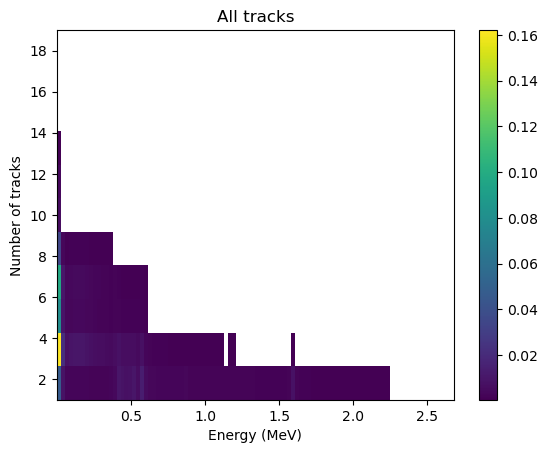

In [13]:
display(full_tracks)
func.energy_track_plots(full_tracks, "All tracks")

,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z,PORT
0,5080000,0,1.068732,168.887195,64,9158,1,375.675,161.675,330.900281,...,384.212773,278.679478,445.580642,0.498749,0.045366,0.000000,12.200000,14.000000,13.534216,1a
1,5080002,0,1.282228,248.187363,42,4241,4,-79.325,344.675,515.180105,...,94.850390,364.689594,517.833734,0.367780,0.074493,0.000000,14.444444,14.125000,14.263647,1a
2,5080002,1,0.654868,69.761558,18,2150,4,-100.325,415.675,603.385913,...,-89.159408,425.914687,608.759268,0.384472,0.085811,0.000000,14.444444,14.125000,14.263647,1a
3,5080002,2,0.147971,14.444444,2,457,4,133.675,360.675,499.470366,...,151.087271,367.376060,502.128486,0.147971,0.147971,0.147971,14.444444,14.125000,14.263647,1a
5,5080004,0,0.474589,33.623009,6,2938,3,15.675,-318.325,149.169202,...,23.303128,-289.613208,154.976143,0.363551,0.326402,0.215392,14.000000,13.750000,11.455763,1a
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137088,12181398,0,0.406761,127.074010,57,7123,2,339.675,-184.325,1108.586850,...,347.408206,-166.931609,1191.748931,0.075444,0.050717,0.000000,14.000000,14.000000,14.621928,2a
137090,12181404,0,0.469805,44.644068,14,4511,6,5.675,310.675,514.352344,...,21.473643,358.153019,521.157722,0.275612,0.134136,0.002530,14.857143,14.881356,13.668509,2a
137091,12181404,1,0.156201,21.028301,4,2111,6,120.675,-449.325,394.931939,...,138.930551,-431.015232,401.397548,0.154934,0.154144,0.152877,14.857143,14.881356,13.668509,2a
137096,12181410,0,0.289894,20.714286,4,3299,4,-67.325,-396.325,918.424894,...,-57.257299,-387.239439,923.537166,0.275602,0.274273,0.260051,15.000000,14.285714,14.723900,2a


No limits applied


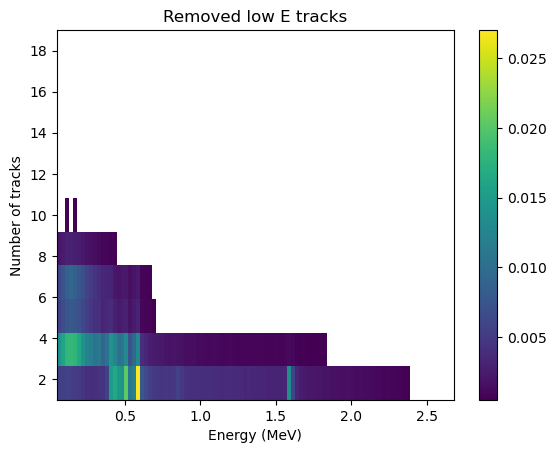

In [14]:
display(low_e_tracks)
func.energy_track_plots(low_e_tracks, "Removed low E tracks")

341696


,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z,PORT
107,5080086,0,1.683154,324.712905,75,7056,1,-240.325,-178.325,1037.969888,...,-217.390057,-41.463176,1044.619150,0.425738,0.077629,0.0,14.875000,14.500000,13.632267,1a
737,5080582,0,1.597251,142.007874,59,6551,1,296.675,-46.325,681.238031,...,337.279082,56.812115,714.750819,0.391053,0.238712,0.0,14.142857,14.500000,13.223831,1a
854,5080676,0,1.594962,141.841206,50,7768,1,179.675,146.675,453.319420,...,273.088557,157.066900,509.242530,0.625310,0.377647,0.0,14.428571,14.666667,13.097077,1a
984,1740022,0,1.595983,240.220791,71,7411,1,187.675,-35.325,409.113469,...,196.685108,54.418912,425.195124,0.514368,0.456328,0.0,13.800000,14.571429,13.871316,1a
1054,1740082,0,1.619501,331.972634,74,7845,1,-10.325,-338.325,191.247312,...,85.790312,-134.035423,305.482562,0.441276,0.031332,0.0,14.714286,14.133333,13.536416,1a
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136694,12180240,0,1.593503,168.933124,59,7329,1,247.675,13.675,810.576047,...,287.754545,23.109780,818.112728,0.430172,0.261936,0.0,14.714286,15.000000,13.402069,2a
136872,12180756,0,1.597874,84.486164,43,8744,1,49.675,-137.325,322.404338,...,95.135160,-112.447335,327.540984,0.254408,0.105188,0.0,13.500000,13.800000,13.682209,2a
136923,12180888,0,1.596929,178.966898,57,6689,1,169.675,129.675,1087.524900,...,292.144829,210.538713,1121.916075,0.362043,0.032287,0.0,14.222222,14.333333,13.040278,2a
136959,12181002,0,1.653133,285.954191,75,8133,3,165.675,10.675,150.269602,...,282.496470,59.901117,237.992998,0.398247,0.115302,0.0,14.000000,14.500000,14.252693,2a


,Cut,Relative Efficiency,Relative Events,Single Cut Efficiency
0,No cuts,100.000000,198958,100.000000
1,Fiducial Cuts,40.720152,81016,40.720152
2,One track cut,64.681051,52402,53.242393
3,Blob overlap cuts,72.560208,38023,71.489963
4,Energy cuts,10.746127,4086,7.606128


No limits applied


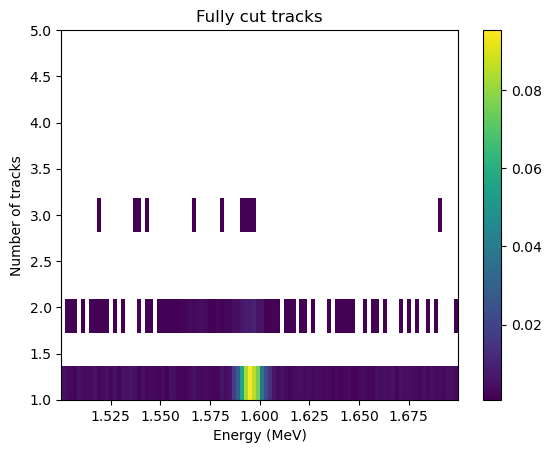

In [15]:
print(len(low_e_tracks.index))
display(cut_tracks)
display(efficiency)
func.energy_track_plots(cut_tracks, "Fully cut tracks")

In [9]:
# apply cuts
low_e_tracks = full_tracks[full_tracks.energy > 0.05]
holder = func.apply_cuts(low_e_tracks, lower_z = 20, upper_z = 1170, r_lim = 415)
cut_tracks = holder[0]
efficiency = holder[1]

Cutting events around fiducial volume related to:
Z range between 20 and 1170
Radius range < 415
Fiducial track cut
Relative Cut efficiency:
Efficiency: 40.72 %
Absolute Cut efficiency:
Efficiency: 40.72 %
One track cut
Relative Cut efficiency:
Efficiency: 64.68 %
Absolute Cut efficiency:
Efficiency: 53.24 %
Blob overlap cut
Relative Cut efficiency:
Efficiency: 72.56 %
Absolute Cut efficiency:
Efficiency: 71.49 %
Energy cut
Relative Cut efficiency:
Efficiency: 10.75 %
Absolute Cut efficiency:
Efficiency: 7.61 %


In [4]:
# find positron events per port
pos_events = func.positron_ports(folder_paths)

Loading positrons from 75_9e-3/PORT_1a/isaura/
Port finished! Tracks available: 13282
Loading positrons from 75_9e-3/PORT_1b/isaura/
Positron events: 12865
Port finished! Tracks available: 25717
Loading positrons from 75_9e-3/PORT_2a/isaura/
Positron events: 9663
Port finished! Tracks available: 34976


In [5]:
display(pos_events)

,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,...,initial_momentum_x,initial_momentum_y,initial_momentum_z,final_momentum_x,final_momentum_y,final_momentum_z,kin_energy,length,creator_proc,final_proc
302,5080008,42,e+,False,40,399.615417,394.366058,536.815430,0.004905,399.746094,...,0.780250,0.557767,1.590467,-0.0,-0.0,0.0,1.415293,1.324204,conv,annihil
1182,5080032,32,e+,False,30,-166.862320,-370.026581,1148.358154,3.770954,-198.535721,...,-0.247377,-0.461457,1.173200,0.0,0.0,-0.0,0.871628,187.018860,conv,annihil
1375,5080036,37,e+,False,35,-65.955795,324.198029,272.437469,1.781441,-22.099428,...,-1.258216,-0.110806,-0.581811,0.0,-0.0,0.0,0.970557,263.940033,conv,annihil
1757,5080048,18,e+,False,16,394.422913,407.527100,535.740845,0.035130,394.485077,...,0.217861,0.929769,-0.199142,0.0,-0.0,0.0,0.590233,0.248721,conv,annihil
1829,5080050,43,e+,False,41,466.010071,219.144073,487.874298,0.656721,466.172241,...,0.595691,-1.389832,-0.308319,0.0,0.0,0.0,1.114628,0.823723,conv,annihil
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571950,12181188,55,e+,False,53,-317.644165,122.913124,780.973267,2.805562,-227.563492,...,-1.560910,-0.481398,-0.572206,0.0,0.0,0.0,1.293640,398.153534,conv,annihil
572070,12181194,29,e+,False,27,388.389008,145.365875,1089.239014,0.848894,388.548676,...,-0.078389,-0.186970,0.119934,-0.0,-0.0,-0.0,0.051679,3.023956,conv,annihil
573711,12181302,91,e+,False,87,210.304977,-88.572311,528.882324,2.638315,209.844193,...,0.204529,-0.242675,-0.472967,0.0,0.0,0.0,0.254208,50.648548,conv,annihil
574540,12181368,34,e+,False,32,366.878693,391.280914,1094.120483,0.133110,365.349640,...,-0.834090,-0.260838,-0.929550,0.0,-0.0,-0.0,0.863383,4.327487,conv,annihil


In [15]:
display(cut_tracks)

,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z,PORT
107,5080086,0,1.683154,324.712905,75,7056,1,-240.325,-178.325,1037.969888,...,-217.390057,-41.463176,1044.619150,0.425738,0.077629,0.0,14.875000,14.500000,13.632267,1a
737,5080582,0,1.597251,142.007874,59,6551,1,296.675,-46.325,681.238031,...,337.279082,56.812115,714.750819,0.391053,0.238712,0.0,14.142857,14.500000,13.223831,1a
854,5080676,0,1.594962,141.841206,50,7768,1,179.675,146.675,453.319420,...,273.088557,157.066900,509.242530,0.625310,0.377647,0.0,14.428571,14.666667,13.097077,1a
984,1740022,0,1.595983,240.220791,71,7411,1,187.675,-35.325,409.113469,...,196.685108,54.418912,425.195124,0.514368,0.456328,0.0,13.800000,14.571429,13.871316,1a
1054,1740082,0,1.619501,331.972634,74,7845,1,-10.325,-338.325,191.247312,...,85.790312,-134.035423,305.482562,0.441276,0.031332,0.0,14.714286,14.133333,13.536416,1a
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136694,12180240,0,1.593503,168.933124,59,7329,1,247.675,13.675,810.576047,...,287.754545,23.109780,818.112728,0.430172,0.261936,0.0,14.714286,15.000000,13.402069,2a
136872,12180756,0,1.597874,84.486164,43,8744,1,49.675,-137.325,322.404338,...,95.135160,-112.447335,327.540984,0.254408,0.105188,0.0,13.500000,13.800000,13.682209,2a
136923,12180888,0,1.596929,178.966898,57,6689,1,169.675,129.675,1087.524900,...,292.144829,210.538713,1121.916075,0.362043,0.032287,0.0,14.222222,14.333333,13.040278,2a
136959,12181002,0,1.653133,285.954191,75,8133,3,165.675,10.675,150.269602,...,282.496470,59.901117,237.992998,0.398247,0.115302,0.0,14.000000,14.500000,14.252693,2a


No handles with labels found to put in legend.


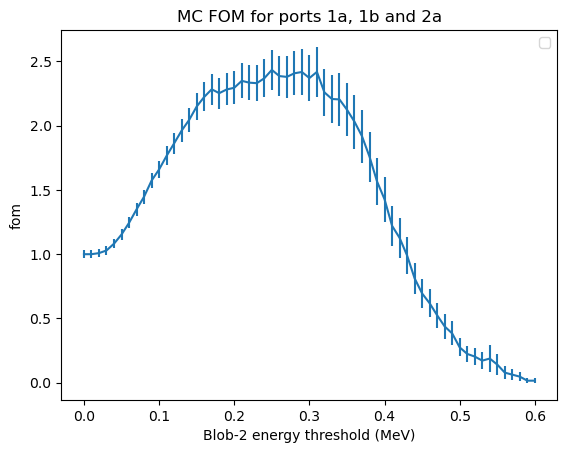

In [17]:
# collect positron events and non-positron events
ecut_positron_df = cut_tracks[cut_tracks['event'].isin(pos_events['event_id'].to_numpy())]
ecut_no_positron_df = cut_tracks[~cut_tracks['event'].isin(pos_events['event_id'].to_numpy())]

cut_list = np.linspace(0,0.6, 61)

fom = func.true_fom_calc(ecut_positron_df, ecut_no_positron_df, cut_list)

ns = fom[2]
nb = fom[3]
fom_erro = np.nan_to_num(fom[1])
fom_out = np.nan_to_num(fom[0])

plt.errorbar(cut_list, fom_out, yerr = fom_erro)
plt.title("MC FOM for ports 1a, 1b and 2a")
plt.xlabel("Blob-2 energy threshold (MeV)")
plt.legend()

plt.ylabel("fom")
plt.show()

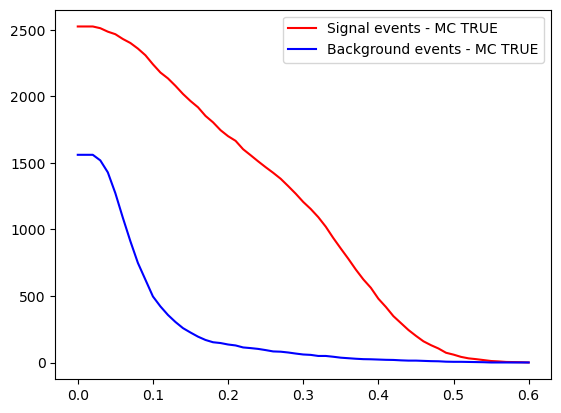

In [19]:
plt.plot(cut_list, ns[:-1], label = "Signal events - MC TRUE", color = 'red')
plt.plot(cut_list, nb[:-1], label = "Background events - MC TRUE", color = 'blue')
plt.legend()
plt.show()

In [ ]:
fom_out = fom_calc_MC(cut_tracks[0], pos_events, cut_list)